# VALID ON AFFECTNET-DB

## Project Configure

In [31]:
from __future__ import absolute_import, division, print_function

%reload_ext autoreload
%autoreload 2

########################################################################
# Declare Project Configure
########################################################################
import os, sys
root_dir = "/mnt/ubuntu1/dntai/projects_merge/EmotiWPrj"
lib_dirs = [os.path.join(root_dir, 'sources')]
for lib in lib_dirs:
    if lib not in sys.path: sys.path.insert(0, lib)
# for
# np.set_printoptions(precision=2, suppress=True, formatter={'float': '{: 0.4f}'.format}, linewidth=1000)

from emotiw19prj.image2d.common   import *

from emotiw19prj.image2d.affectnet.dataset import AffectNetEmotiWDataset
from emotiw19prj.image2d.dataaug  import train_aug, valid_aug
from emotiw19prj.image2d.dataload import Face2DEmotiWBalancedDataLoader
from emotiw19prj.image2d.datagen  import DataGenerator
from emotiw19prj.image2d.dataaug  import vggface2_preprocessing_input, vggface2_postprocessing_input, \
                                         nasnet_preprocess_input, densenet_preprocess_input, \
                                         inceptionresnetv2_preprocess_input, xception_preprocess_input
from emotiw19prj.image2d.model.model_vggface2_ft import VGGFace2_FineTuning_EmotionRecognition_V0
from emotiw19prj.image2d.model.model_fine_tuning import FineTuning_EmotionRecognition_V0

from dntai.utils.model_reports import plot_confusion_matrix, model_report, print_summary, buffer_print_string
from dntai.utils.files import safe_move, safe_copy

## 1. Setup Environments

In [32]:
# Parameters
parser = argparse.ArgumentParser(description='Facial Emotion Recognition - AFFECTNET-DB Dataset')
parser.add_argument('--project_name', type=str, default="Facial Emotion Recognition  - AFFECTNET-DB Dataset", metavar='project_name', help='')

parser.add_argument('--gpus',   type=str, default="['2']", help='')

parser.add_argument('--db_file' ,type=str, default=root_dir + "/data/affectnet/kfold/emotiw_train_01.hdf5", metavar='db_file', help='')
parser.add_argument('--db_root' ,type=str, default=root_dir + "/dataset/affectnet_extracted", metavar='db_root', help='')

parser.add_argument('--batch_size'       , type=int, default=32, help='')

parser.add_argument('--weight_path'  , type=str  , default="/mnt/ubuntu1/dntai/projects_merge/EmotiWPrj/data/results/" + 
                    "image2d/affectnet/affectnet_xception/190515_01/checkpoints/" + 
                    "affectnet_xception_01_weights_190516080740_epoch-61_val_loss-1.49_val_acc-0.57.h5", help='')

parser.add_argument('--logs_path'    , type=str  , default="/mnt/ubuntu1/dntai/projects_merge/EmotiWPrj/data/results/" + 
                    "image2d/affectnet/affectnet_xception/190515_01/logs/" + 
                    "03_affectnet_xception_01_logs.csv", help='')

parser.add_argument('--filter_epoch' , type=int  , default=61, help='')

parser.add_argument('--backup_path' , type=str  , default="/mnt/ubuntu1/dntai/projects_merge/EmotiWPrj/data/results/" + 
                    "image2d/affectnet/affectnet_xception/190515_01/weights/model1/", help='')

parser.add_argument('--filter_time' , type=int  , default=190516080740, help='')

parser.add_argument('--training_scheme' ,type=str, default=root_dir + "/data/affectnet/kfold/normal_manual_training.npz", metavar='training_scheme', help='')

args, _ = parser.parse_known_args()
params  = vars(args)
params["gpus"] = eval(params["gpus"])
print("parameters: ")
for key in params.keys(): print("+ %s: %s"%(key,params[key]))

parameters: 
+ filter_epoch: 61
+ training_scheme: /mnt/ubuntu1/dntai/projects_merge/EmotiWPrj/data/affectnet/kfold/normal_manual_training.npz
+ batch_size: 32
+ gpus: ['2']
+ db_file: /mnt/ubuntu1/dntai/projects_merge/EmotiWPrj/data/affectnet/kfold/emotiw_train_01.hdf5
+ logs_path: /mnt/ubuntu1/dntai/projects_merge/EmotiWPrj/data/results/image2d/affectnet/affectnet_xception/190515_01/logs/03_affectnet_xception_01_logs.csv
+ backup_path: /mnt/ubuntu1/dntai/projects_merge/EmotiWPrj/data/results/image2d/affectnet/affectnet_xception/190515_01/weights/model1/
+ project_name: Facial Emotion Recognition  - AFFECTNET-DB Dataset
+ filter_time: 190516080740
+ db_root: /mnt/ubuntu1/dntai/projects_merge/EmotiWPrj/dataset/affectnet_extracted
+ weight_path: /mnt/ubuntu1/dntai/projects_merge/EmotiWPrj/data/results/image2d/affectnet/affectnet_xception/190515_01/checkpoints/affectnet_xception_01_weights_190516080740_epoch-61_val_loss-1.49_val_acc-0.57.h5


In [35]:
# Choose gpus, init session
choose_keras_environment(gpus = params["gpus"], keras_backend = "tensorflow", verbose = 1)
init_session()
check_tensorflow_environment()

Environment GPUs:
+ Choose GPUs:  2
+ Keras backend:  tensorflow
TensorFlow Version: 1.9.0
Default GPU Device: /device:GPU:0


## 2. Setup Predictions

In [36]:
# Dataset Configuration
dataset_info  = dict(db_file = params["db_file"], db_root = params["db_root"])
print("dataset_info: ")
for key in dataset_info.keys(): print("+ %s: %s"%(key,dataset_info[key]))

dataset_info: 
+ db_root: /mnt/ubuntu1/dntai/projects_merge/EmotiWPrj/dataset/affectnet_extracted
+ db_file: /mnt/ubuntu1/dntai/projects_merge/EmotiWPrj/data/affectnet/kfold/emotiw_train_01.hdf5


In [38]:
ds = AffectNetEmotiWDataset(**dataset_info)
ds.load_scheme(params["training_scheme"])

valid_transforms = valid_aug(224)
valid_loader = Face2DEmotiWBalancedDataLoader(
    ds.x_valid, ds.y_valid, 7, mode = "valid", transforms = valid_transforms,
    type_bbox = "xywh", expanding_bbox = (0.2, 0.2, 0.2, 0.2))

valid_gen = DataGenerator(dataloader = valid_loader, 
                          preprocessing_image_fn = xception_preprocess_input,
                          batch_size = params["batch_size"], 
                          shuffle = False, seed = None )

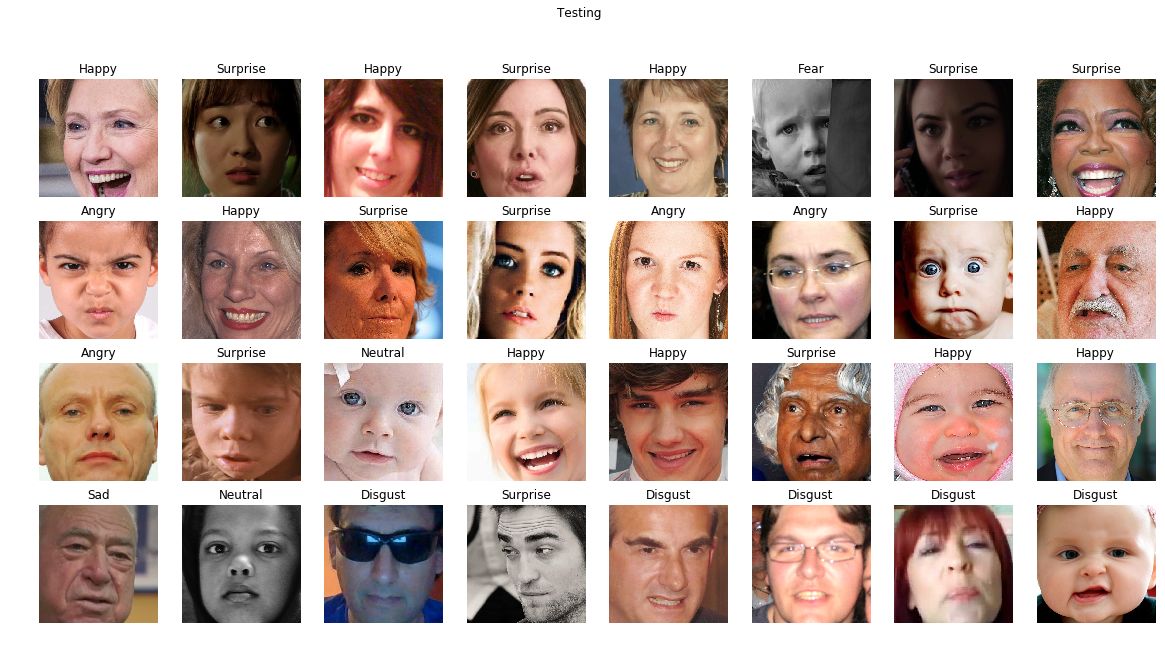

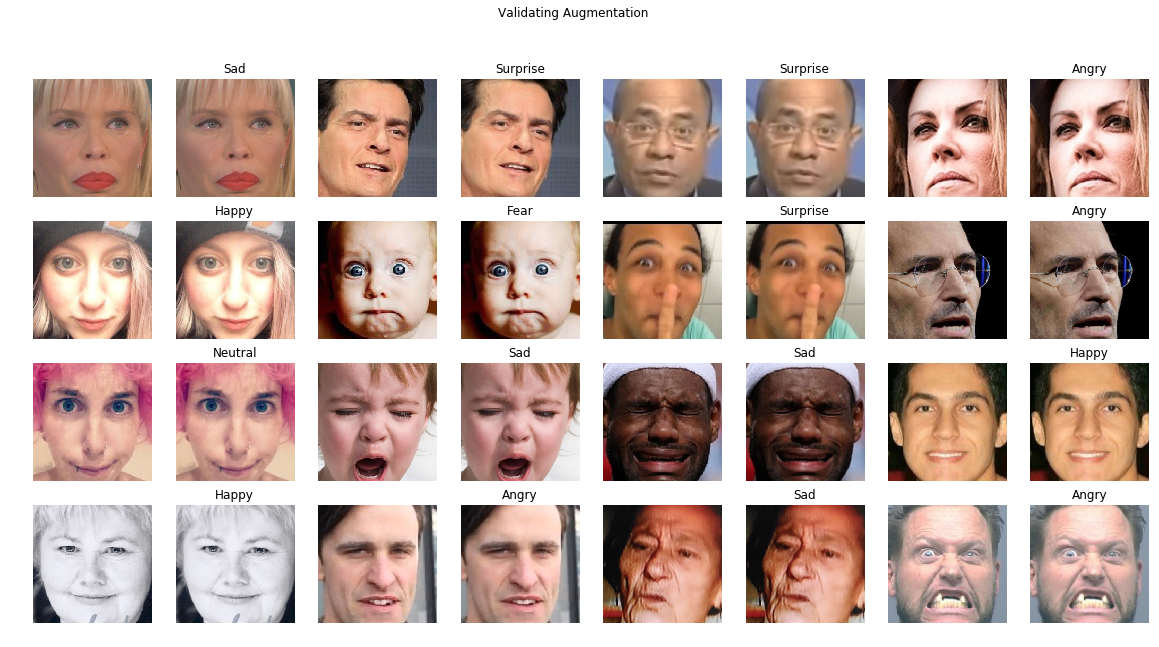

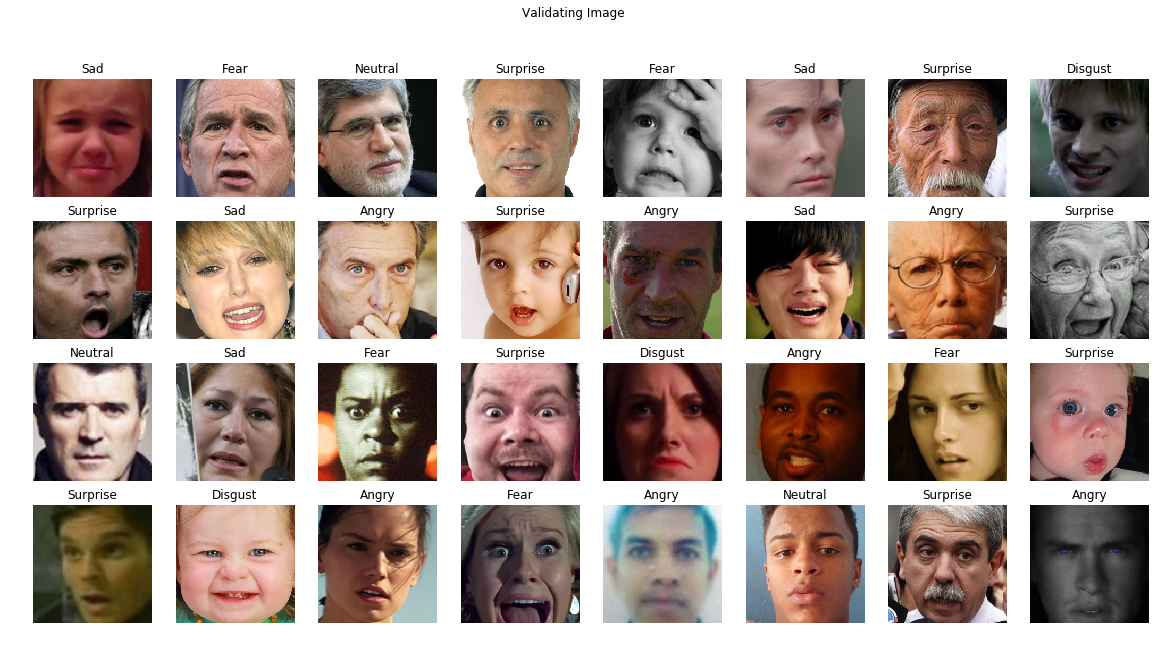

Number of images in the training dataset:	283901


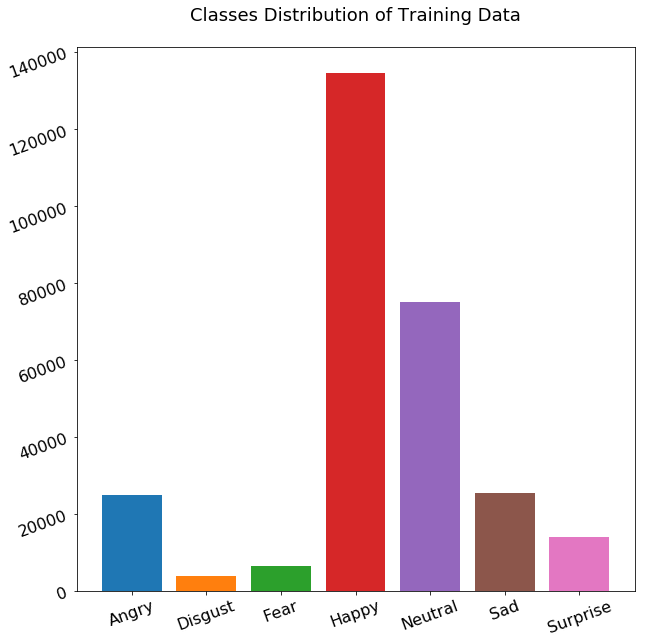

Number of images in the training dataset:	  3500


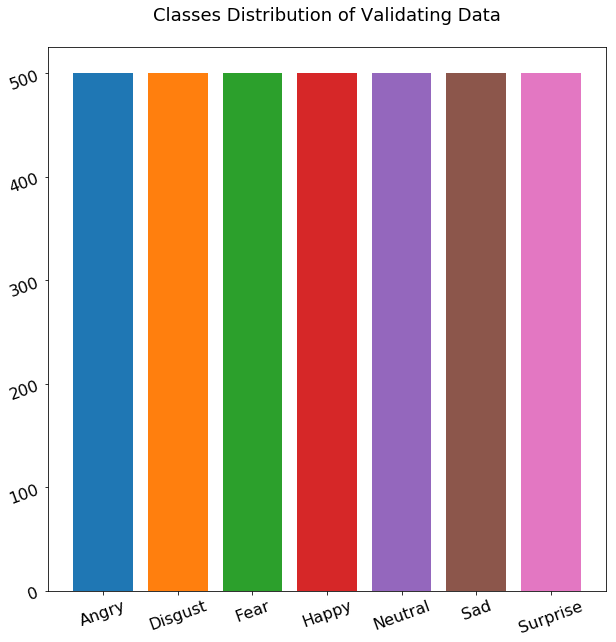

In [39]:
ds.view_images(ds.x_valid, ds.y_valid, mode = "valid", title = "Testing");
ds.test_aug(ds.x_valid, ds.y_valid, valid_aug(224), 
            mode = "valid", title = "Validating Augmentation", rows = 4, cols = 4)
valid_loader.view("Validating Image")
ds.view_summary(x = ds.x_train, y = ds.y_train, mode = "train", title = "Training Data")
ds.view_summary(x = ds.x_valid, y = ds.y_valid, mode = "valid", title = "Validating Data")

In [40]:
# Model
from keras.models import load_model
K.clear_session()

model = load_model(params["weight_path"])

## 3. Backup Data

### Weight

In [41]:
# backup weights
weight_name = os.path.basename(params["weight_path"])
safe_copy(params["weight_path"], os.path.join(params["backup_path"], weight_name))

In [42]:
from matplotlib.ticker import MaxNLocator
from datetime import datetime
print(params["backup_path"])
for path in os.listdir(params["backup_path"]): print("+", path)

/mnt/ubuntu1/dntai/projects_merge/EmotiWPrj/data/results/image2d/affectnet/affectnet_xception/190515_01/weights/model1/
+ affectnet_xception_01_weights_190515151805_epoch-49_val_loss-1.38_val_acc-0.56.h5.valid.reports.txt
+ affectnet_xception_01_weights_190515151805_epoch-49_val_loss-1.38_val_acc-0.56.h5.history.png
+ affectnet_xception_01_weights_190516080740_epoch-61_val_loss-1.49_val_acc-0.57.h5
+ affectnet_xception_01_weights_190515151805_epoch-49_val_loss-1.38_val_acc-0.56.h5.model.txt
+ affectnet_xception_01_weights_190515151805_epoch-49_val_loss-1.38_val_acc-0.56.h5.valid.reports.npz
+ affectnet_xception_01_weights_190515151805_epoch-49_val_loss-1.38_val_acc-0.56.h5.logs.csv
+ affectnet_xception_01_weights_190515151805_epoch-49_val_loss-1.38_val_acc-0.56.h5.valid.pred.npz
+ affectnet_xception_01_weights_190515151805_epoch-49_val_loss-1.38_val_acc-0.56.h5.model.png
+ affectnet_xception_01_weights_190515151805_epoch-49_val_loss-1.38_val_acc-0.56.h5
+ affectnet_xception_01_weights_

### Logs

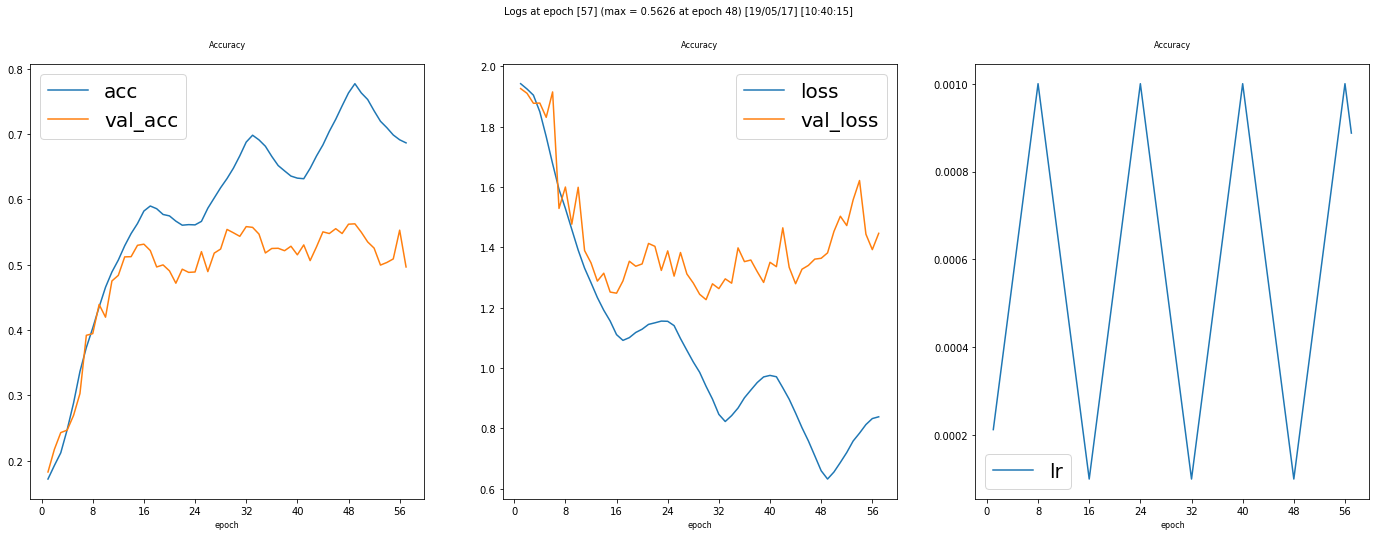

In [43]:
# read logs
show_groups  = [{"x": "epoch", "y": ['acc', 'val_acc']}
                , {"x": "epoch", "y": ['loss', 'val_loss']}
                , {"x": "epoch", "y": ['lr']}
               ]
    
df_history = pd.read_csv(params["logs_path"])
df_history = df_history.query("epoch<=%d and date<=%d"%(params["filter_epoch"], params["filter_time"]))
df_history = df_history.drop_duplicates(subset="epoch", keep='last')

# show logs
plt.figure(figsize=(len(show_groups)*8, 8))
for idx, group in enumerate(show_groups):
    ax = plt.subplot(1,len(show_groups), idx + 1)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    df_history.plot(x = group["x"], y = group["y"], ax = ax, fontsize=10)
    plt.legend(fontsize = 20)
    plt.xlabel("epoch", fontsize = 8)
    plt.title("Accuracy\n", fontsize = 8)
# for   
s_time   = datetime.fromtimestamp(os.path.getmtime(params["logs_path"])).strftime("[%y/%m/%d] [%H:%M:%S]")
plt.suptitle("Logs at epoch [%d] (max = %.4f at epoch %d) %s\n" 
    %(df_history["epoch"].max(), df_history["val_acc"].max(), 
      df_history["val_acc"].values.argmax(), s_time), fontsize=10);

# save logs
plt.savefig(os.path.join(params["backup_path"], weight_name + '.history.png'))
df_history.to_csv(os.path.join(params["backup_path"], weight_name + '.logs.csv'), index = False)

### Model

In [44]:
# model
save_keras_model(model, 
                 save_dir=params["backup_path"], 
                 save_name=weight_name + '.model', verbose=0)

In [45]:
print(params["backup_path"])
for path in os.listdir(params["backup_path"]): print("+", path)

/mnt/ubuntu1/dntai/projects_merge/EmotiWPrj/data/results/image2d/affectnet/affectnet_xception/190515_01/weights/model1/
+ affectnet_xception_01_weights_190516080740_epoch-61_val_loss-1.49_val_acc-0.57.h5.model.txt
+ affectnet_xception_01_weights_190515151805_epoch-49_val_loss-1.38_val_acc-0.56.h5.valid.reports.txt
+ affectnet_xception_01_weights_190515151805_epoch-49_val_loss-1.38_val_acc-0.56.h5.history.png
+ affectnet_xception_01_weights_190516080740_epoch-61_val_loss-1.49_val_acc-0.57.h5.model.png
+ affectnet_xception_01_weights_190516080740_epoch-61_val_loss-1.49_val_acc-0.57.h5
+ affectnet_xception_01_weights_190515151805_epoch-49_val_loss-1.38_val_acc-0.56.h5.model.txt
+ affectnet_xception_01_weights_190515151805_epoch-49_val_loss-1.38_val_acc-0.56.h5.valid.reports.npz
+ affectnet_xception_01_weights_190516080740_epoch-61_val_loss-1.49_val_acc-0.57.h5.model.yaml
+ affectnet_xception_01_weights_190516080740_epoch-61_val_loss-1.49_val_acc-0.57.h5.logs.csv
+ affectnet_xception_01_we

In [46]:
# from IPython.display import Image
# Image(filename='/mnt/ubuntu1/dntai/projects_merge/EmotiWPrj/data/results/image2d/rafdb/affectnet_vggface2_resnes50_ft/190510_01/weights/model1/affectnet_facevgg2_resnet50_ft_01_weights_190510213531_epoch-67_val_loss-0.95_val_acc-0.85.h5.cm.png') 

## 4. Prediction

### Evaluation

In [47]:
y_pred = model.predict_generator(valid_gen)

In [48]:
y_pred_label = np.argmax(y_pred, axis = 1)
y_true_label = ds.y_valid

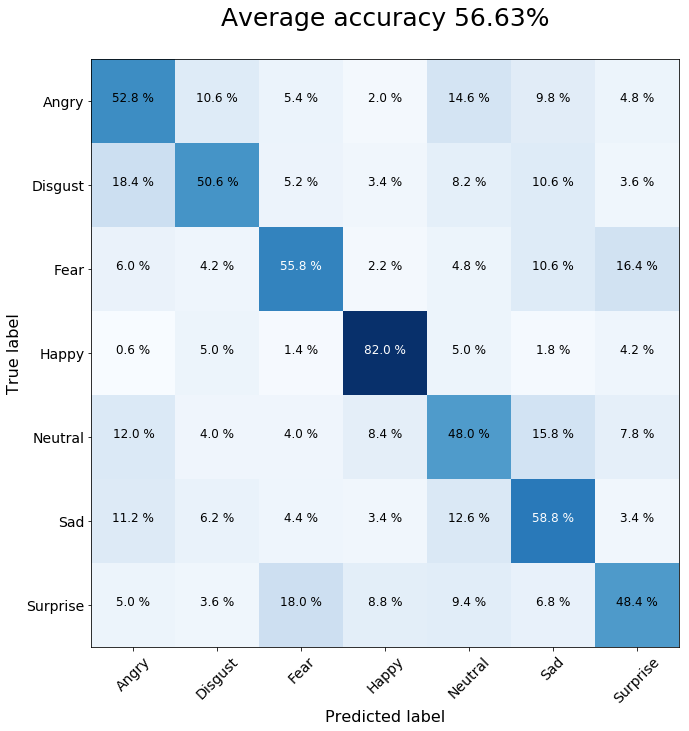

In [49]:
plt.figure(figsize=(12,10))
plot_confusion_matrix(y_true_label, y_pred_label, 
                    classes = ds.emotiw_name, 
                    verbose = 0, precision = 1, text_size = 12, 
                    title_size = 25, axis_label_size = 16, tick_size = 14,
                    title="Average accuracy {acc:.2f}%\n", 
                    save_path = os.path.join(params["backup_path"], weight_name + ".cm.png"))

### Metrics

In [50]:
save_summary = model_report(y_true_label, y_pred_label, label_names = ds.emotiw_name)
string_summary = buffer_print_string(print_summary, save_summary = save_summary)
with open(os.path.join(params["backup_path"], weight_name + ".valid.reports.txt"), "w") as f:
    f.writelines(string_summary)
np.savez(os.path.join(params["backup_path"], weight_name + ".valid.reports.npz"), **save_summary)

In [51]:
summary_file = os.path.join(params["backup_path"], weight_name + ".valid.reports.txt")
!cat $summary_file

Classification Report: 
              precision    recall  f1-score   support

      Angry       0.50      0.53      0.51       500
    Disgust       0.60      0.51      0.55       500
       Fear       0.59      0.56      0.57       500
      Happy       0.74      0.82      0.78       500
    Neutral       0.47      0.48      0.47       500
        Sad       0.51      0.59      0.55       500
   Surprise       0.55      0.48      0.51       500

avg / total       0.57      0.57      0.56      3500

Confustion Matrix Int: 
 [[264  53  27  10  73  49  24]
 [ 92 253  26  17  41  53  18]
 [ 30  21 279  11  24  53  82]
 [  3  25   7 410  25   9  21]
 [ 60  20  20  42 240  79  39]
 [ 56  31  22  17  63 294  17]
 [ 25  18  90  44  47  34 242]]

Confustion Matrix Norm: 
 [[52.8 10.6  5.4  2.  14.6  9.8  4.8]
 [18.4 50.6  5.2  3.4  8.2 10.6  3.6]
 [ 6.   4.2 55.8  2.2  4.8 10.6 16.4]
 [ 0.6  5.   1.4 82.   5.   1.8  4.2]
 [12.   4.   4.   8.4 48.  15.8  7.8]
 [11.2  6.2  4.4  3.4 12.6 58.8  3.

### Save Prediction

In [52]:
files = np.array([os.path.splitext(os.path.basename(file))[0] for file in ds.x_valid["image"]])

save_data = dict(
    name  = files, 
    preds = y_pred,
    pred_label = y_pred_label, 
    true_label = y_true_label,
    labels = ds.emotiw_name
)

np.savez(os.path.join(params["backup_path"], weight_name + ".valid.pred.npz"), **save_data)

## 5. Feature Extraction

In [53]:
def get_output_layer(model, layer_name):
    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    layer = layer_dict[layer_name]
    return layer
# get_output_layer

In [54]:
# import keras.backend as K
# from keras.layers import Lambda
# feature_layer    = get_output_layer(model, "features")
# prediction_layer = get_output_layer(model, "predictions")
# tensor_fn        = K.function([model.layers[0].input], [feature_layer.output, prediction_layer.output])

In [55]:
# batch_size    = 8
# image_batch   = np.zeros((batch_size,) + valid_loader[0][0].shape, dtype=np.float32)
# n_data        = len(valid_loader)

In [56]:
# n_chunk       = int((n_data + batch_size - 1) / batch_size)

# files         = np.array([os.path.splitext(os.path.basename(file))[0] for file in ds.x_valid["image"]])
# features      = None
# preds         = None

In [57]:
# for i_chunk in tqdm.tqdm(range(n_chunk)):
#     from_pos = i_chunk * batch_size
#     to_pos   = min(n_data, (i_chunk+1)*batch_size)
#     for idx in range(0, to_pos - from_pos):
#         image_batch[idx, ...] = valid_loader[idx + from_pos][0]
#         image_batch = vggface2_preprocessing_input(image_batch)
#     feature, pred = tensor_fn([image_batch])
#     feature = K.eval(K.l2_normalize(feature, axis = 0))
#     if features is None:
#         features = feature
#     else:
#         features = np.vstack([features, feature])

#     if preds is None:
#         preds = pred
#     else:
#         preds = np.vstack([preds, pred])
# #  for

In [58]:
# np.savez(os.path.join(params["backup_path"], weight_name + ".valid.features.npz"), 
#          features = features, preds = preds, files = files)

## Appendix

### Model Layout

In [59]:
with open(os.path.join(params["backup_path"], weight_name + '.model.txt')) as f: 
    print("".join(f.readlines()))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [60]:
print(params["backup_path"])
for path in os.listdir(params["backup_path"]): print("+", path)

/mnt/ubuntu1/dntai/projects_merge/EmotiWPrj/data/results/image2d/affectnet/affectnet_xception/190515_01/weights/model1/
+ affectnet_xception_01_weights_190516080740_epoch-61_val_loss-1.49_val_acc-0.57.h5.cm.png
+ affectnet_xception_01_weights_190516080740_epoch-61_val_loss-1.49_val_acc-0.57.h5.model.txt
+ affectnet_xception_01_weights_190515151805_epoch-49_val_loss-1.38_val_acc-0.56.h5.valid.reports.txt
+ affectnet_xception_01_weights_190515151805_epoch-49_val_loss-1.38_val_acc-0.56.h5.history.png
+ affectnet_xception_01_weights_190516080740_epoch-61_val_loss-1.49_val_acc-0.57.h5.model.png
+ affectnet_xception_01_weights_190516080740_epoch-61_val_loss-1.49_val_acc-0.57.h5
+ affectnet_xception_01_weights_190515151805_epoch-49_val_loss-1.38_val_acc-0.56.h5.model.txt
+ affectnet_xception_01_weights_190516080740_epoch-61_val_loss-1.49_val_acc-0.57.h5.valid.pred.npz
+ affectnet_xception_01_weights_190515151805_epoch-49_val_loss-1.38_val_acc-0.56.h5.valid.reports.npz
+ affectnet_xception_01_